## A Tale of Two Problems, Part 2: Benchmarking Synthetic Data
### ChBE 6746/4746 Spring 2023 Group 3

In this notebook, our group compared several different solvers from the Gradient-Free-Solvers package by SimonBlanke: https://github.com/SimonBlanke/Gradient-Free-Optimizers

TA Suryateja Ravutla graciously provided test problems in files `bcp8.npy` as well as starting code to load problems and visualize 2D problems.

### Load Test Problems

In [1]:
# load benchmarks problems

import numpy as np

bcp = np.load('bcp8.npy', allow_pickle=True).item()
eqc = np.load('eqcS.npy', allow_pickle=True).item()

class prb:   # this will be your black box function
    def __init__(self, prob, noisy_level):
        # function for generating data
        self.func=prob['func']
        # number of constraints
        self.n_con=prob['n_con']
        # noise level
        self.nl=noisy_level
        # constraints
        self.con=[]
        for i in range(self.n_con):
            self.con.append(prob['con'+str(i+1)])
    def datcol(self,x):
        try:
            # eval takes string type input and evaluates python code. Input can be
            # a mathematical function or a python function which will be called.
            y = eval(self.func)
        except:
            x = np.array([x])
            y = eval(self.func)
        return float(y)
    def constraint(self, x):
        # Appears to evaluate if the constraints are satisfied
        # returns 1 if all constraints are satisfied, else -1
        try:     
            m,n=np.shape(x)
        except:
            x = np.array([x])
            m,n=np.shape(x)
        y=np.empty((self.n_con))
        for i in range(self.n_con):
            y[i]=eval(self.con[i])     
        if y.all() == 1.:
            label = 1.
        else:
            label = -1.
        return label

class benchmark:
    def __init__(self, func, noisy_level):
        self.func = str(func)
        self.nl = noisy_level
    def datcol(self, x):
        try:
            y = eval(self.func)
        except:
            x = np.array([x])
            y = eval(self.func)
        return float(y)

### Example Visualization of 2D Problem `BeckerLago`

BeckerLago function:
(-5 + np.sqrt(x[:,0]**2))*(-5 + np.sqrt(x[:,0]**2)) + (-5 + np.sqrt(x[:,1]**2))*(-5 + np.sqrt(x[:,1]**2))
lower bounds:
[4.5 4.5]
upper bounds:
[5.5 5.5]



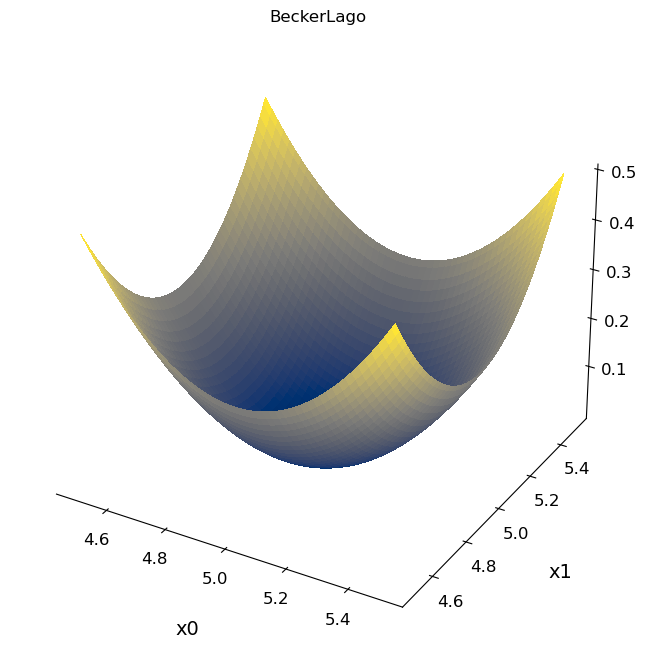

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# source contains problems as numpy array - really a dictionary
# params of bcp dictionary
# yopt - optimal value
# xopt - optimal solution
# xlb - lower bound
# xub - upper bound
# n - dimensionality
# func - function to be evaluated - exists as string version of argument where x[:,0] is first variable and x[:,1] is second variable

# names = list(bcp.keys())
# for i in names:
for i in ['BeckerLago']:
    # n defines dimensionality - ensures we are only plotting 2D problems
    if bcp[i]['n'] == 2:
        prob = bcp[i]
        xlb = prob['xlb']
        xub = prob['xub']
        # pass problem to benchmark class to enable evaluation
        prbf = benchmark(prob['func'],0)
        bounds = np.array([xlb, xub])
        x = np.linspace(bounds[0,0],bounds[1,0],100)
        y = np.linspace(bounds[0,1],bounds[1,1],100)

        X,Y = np.meshgrid(x,y)
        f = prob['func'].replace("x[:,0]", "X").replace("x[:,1]", "Y")
        Z = eval(f)

        fig = plt.figure(figsize=(8,8), dpi=100)
        ax = fig.add_subplot(111, projection='3d')
        # plt.tight_layout(rect=(4, 1, 1, 1))

        print(
            f'{i} function:\n'
            f'{prob["func"]}\n'
            f'lower bounds:\n'
            f'{xlb}\n'
            f'upper bounds:\n'
            f'{xub}\n'
            # f'number of constraints:\n'
            # f'{prob["n_con"]}'
        )

        # Plot a 3D surface
        ax.plot_surface(X, Y, Z, cmap="cividis", antialiased=False)
        ax.set_xlabel('x0',labelpad= 20, fontsize=14)
        ax.set_ylabel('x1',labelpad= 20, fontsize=14)
        ax.set_zlabel('f(x0,x1)',labelpad= 20, fontsize=14)
        ax.set_title(i)
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        ax.zaxis.set_tick_params(labelsize=12)
        ax.grid(False)
        plt.show()

In [3]:
n = 0
for key, value in eqc.items():
    if 'n_con' in value.keys() and value['n_con'] > 0:
        n += 1
print(n)
print(len(eqc.keys()))

347
369


### Identify Valid Problems

In [4]:
import numbers

def get_valid_problems(source, names):
    """ 
    Some provided solutions may be invalid. This function returns valid/invalid solutions
    """

    valid_problems = []
    invalid_problems = []
    for name in names: 
        dims = source[f'{name}']['n']
        try:
            assert len(source[f'{name}']['xub']) == dims and len(source[f'{name}']['xlb']) == dims
            assert len(source[f'{name}']['xopt']) == dims and isinstance(source[f'{name}']['yopt'], numbers.Number)
            assert ('n_con' not in source[f'{name}'].keys()) or ('n_con' in source[f'{name}'].keys() and source[f'{name}']['n_con'] == 0)
            valid_problems.append(name)
        except:
            invalid_problems.append(name)
            continue

    # print(f"There are {len(valid_problems)} valid problems and {len(invalid_problems)} invalid problems")
    
    return valid_problems, invalid_problems

names_bcp = list(bcp.keys())
names_eqc = list(eqc.keys())
bcp_valid_probs, bcp_invalid_probs = get_valid_problems(bcp, names_bcp)
eqc_valid_probs, eqc_invalid_probs = get_valid_problems(eqc, names_eqc)

all_valid_probs = bcp_valid_probs + eqc_valid_probs
bcp_valid_probs.sort()
eqc_valid_probs.sort()
all_valid_probs.sort()
print(f'bcp valid problems: {len(bcp_valid_probs)}')
print(f'{bcp_valid_probs}\n')
print(f'eqc valid problems: {len(eqc_valid_probs)}')
print(f'{eqc_valid_probs}\n')
print(f'total valid problems: {len(all_valid_probs)}')
print(all_valid_probs)

bcp_valid_dims = [bcp[i]['n'] for i in bcp_valid_probs]
bcp_valid_functions = [
    bcp[i]['func'].replace(':,', '').replace('[', '').replace(']', '')
    for i in bcp_valid_probs
]

df_bcp = pd.DataFrame({
    'Name': bcp_valid_probs,
    'Dimensions': bcp_valid_dims,
    'Function': bcp_valid_functions
})
df_bcp.to_csv('bcp_valid_probs.csv')


bcp valid problems: 263
['3pk', 'AluffiPentini', 'BeckerLago', 'Camel3', 'Camel6', 'DekkersAarts', 'Expo', 'GoldPrice', 'Hartman3', 'Hosaki', 'MeyerRoth', 'ModRosenbrock', 'MultiGauss', 'Neumaier2', 'Neumaier3', 'Paviani', 'PowellQ', 'PriceTransistor', 'Shekel10', 'Shekel7', 'Shekelfox10', 'Shekelfox5', 'Wood', 'aircrftb', 'arglinb', 'arglinc', 'biggs3', 'biggs5', 'biggs6', 'biggsb1', 'box3', 'bqp1var', 'brownal', 'brownbs', 'brownden', 'camel1', 'chnrosnb', 'cliff', 'concha1', 'concha10', 'concha11', 'concha12', 'concha2', 'concha3', 'concha4', 'concha5', 'concha5a', 'concha8', 'concha9', 'cube', 'denschna', 'denschnb', 'denschnc', 'denschnd', 'denschne', 'denschnf', 'dixon3dq', 'draper1', 'draperg', 'draperj', 'drapero', 'eigena', 'eigenals', 'eigenb', 'eigenbls', 'engval2', 'errinros', 'ex005', 'ex4_1_1', 'ex4_1_2', 'ex4_1_3', 'ex4_1_4', 'ex4_1_5', 'ex4_1_6', 'ex4_1_7', 'ex8_1_3', 'ex8_1_4', 'ex8_1_5', 'ex8_1_6', 'explin', 'explin2', 'expquad', 'extrosnb', 'fermat2_eps', 'fermat2_va

### Evaluate Dimensionality

Here we evaluate overall dimensionality based on number of problems and percentage of problems:

In [5]:
def get_dimensions(list_problems:list):
    dict_dim = {}
    for problem in list_problems:
        dim = bcp[problem]['n']
        if dim not in dict_dim.keys():
            dict_dim[dim] = 1
        else:
            dict_dim[dim] += 1 
    dict_dim = dict(sorted(dict_dim.items()))
    return dict_dim

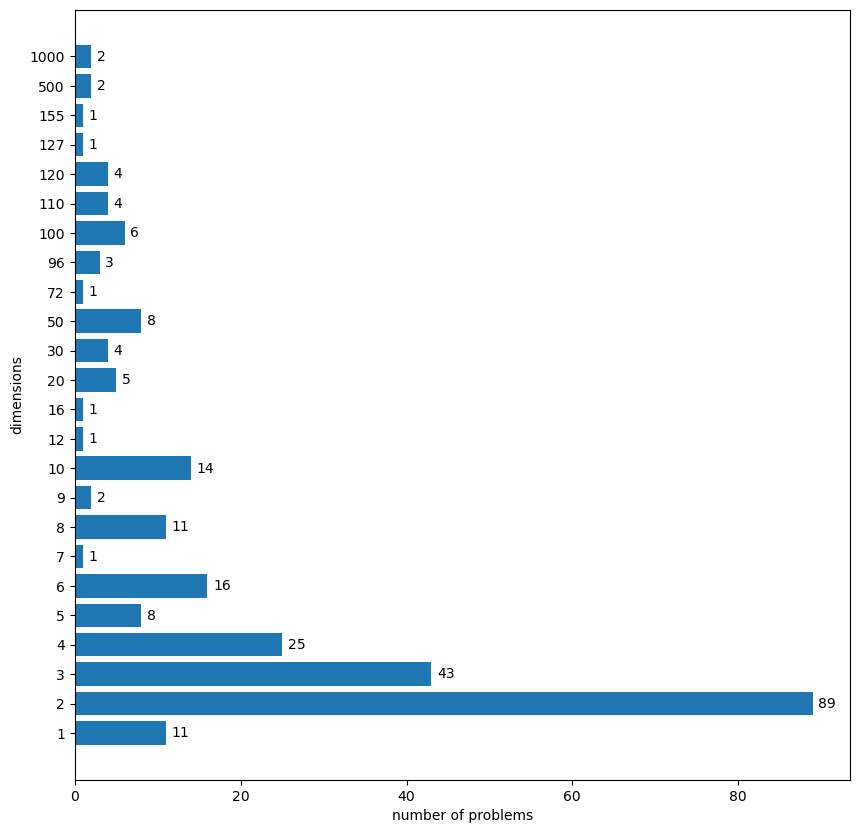

In [6]:
dict_dim = get_dimensions(bcp_valid_probs)
dims = list(dict_dim.keys())
dims = [str(i) for i in dims]
n_probs = list(dict_dim.values())

fig, ax = plt.subplots(figsize=(10,10), dpi=100)
bars = ax.barh(dims, n_probs)
ax.set_xlabel('number of problems')
ax.set_ylabel('dimensions')
ax.bar_label(bars, padding=4);

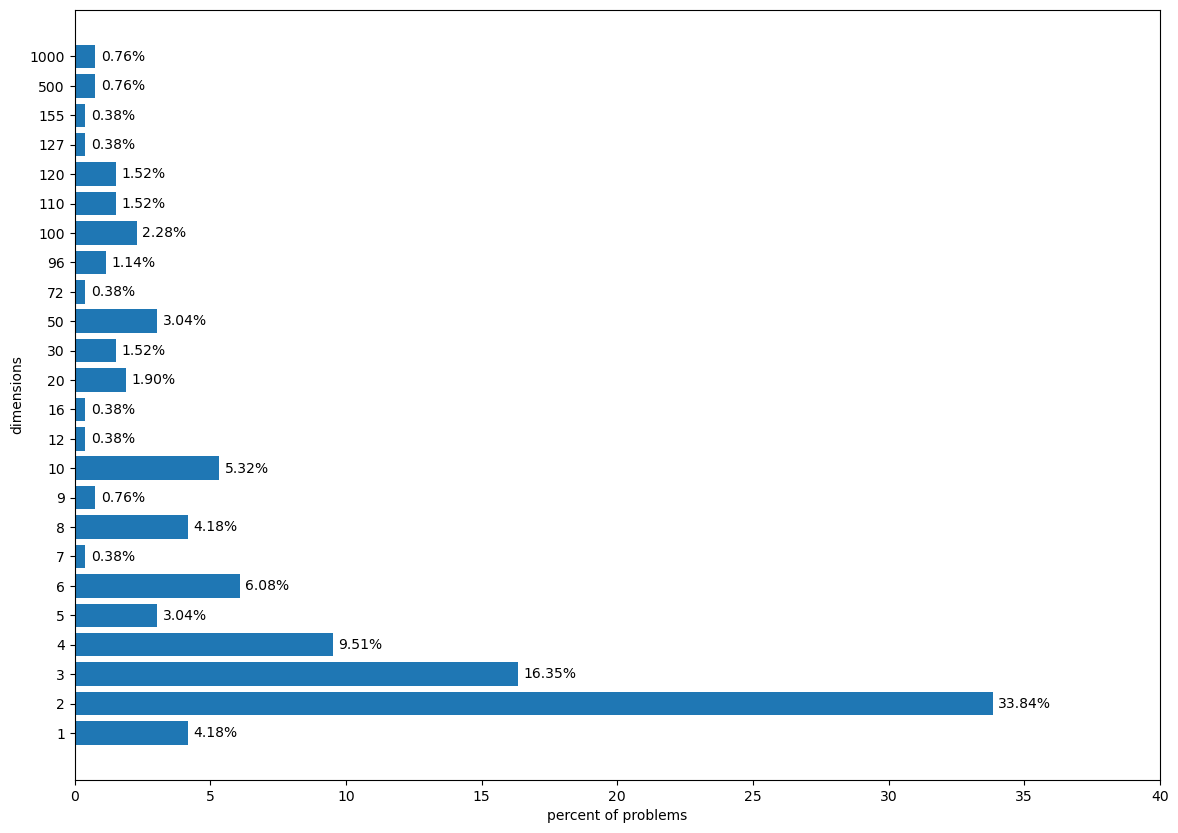

In [7]:
percent_probs = []
sum_probs = len(bcp_valid_probs)
for i in n_probs:
    percent_probs.append(100*i/sum_probs)

fig, ax = plt.subplots(figsize=(14,10), dpi=100)
bars = ax.barh(dims, percent_probs)
ax.set_xlabel('percent of problems')
ax.set_ylabel('dimensions')
ax.bar_label(bars, fmt='%.2f%%', padding=4)
ax.set_xlim(right=40);

### Evaluate Convexity

We tried to evaluate the convexity of each problem by calculating the eigenvalues from the Hessian matrix. However, we ran into issues when solutions for the partial derivatives could not be found within the given bounds for certain problems, even for 2d problems for which the convexity could be deduced visually from its plot, such as `AluffiPentini`.

Code was adapted from the following websites:  
https://towardsdatascience.com/hessian-matrix-and-optimization-problems-in-python-3-8-f7cd2a615371  
https://stackoverflow.com/questions/9492944/sympy-arbitrary-number-of-symbols 

In [8]:
# Functions for finding convexity

import numpy as np
from sympy import symbols, Eq, solve, diff, Matrix, pprint


def solve_for_zero(x, func, xlb, xub):
	"""
	Solve the null equation for f_partial and return the stationary coordinate.
	"""
	stationary_set = []
	for i in range(len(x)):
		eqn = Eq(func, 0)
		soln = solve(eqn, x[i])
		stationary_set.append(
			[v for v in soln if (v.is_real and v > xlb and v < xub)]
		)
		# stationary_set.append(soln)

	return stationary_set


def get_stationary_point(stationary_sets, n):
	"""
	Evaluates set of solutions (list of lists) for stationary point and returns
	a single stationary point.
	"""
	stationary_point = []
	dict_soln_idx = {}
	for i in range(len(stationary_sets)):  # set
		valid = 0
		invalid = 0
		soln_set = stationary_sets[i]
		for j in range(n):  # soln within set
			soln = soln_set[j]
			soln_idx = 0
			if soln == []:
				invalid += 1
			else:
				valid += 1
				soln_idx = j
		if valid == n:
			stationary_point = soln_set
		elif valid == 1:
			dict_soln_idx[soln_idx] = i
	if stationary_point == []:  # at least one soln is invalid in all sets
		for j in range(n):
			if j in dict_soln_idx.keys():
				i = dict_soln_idx.get(j)
				stationary_point.append(stationary_sets[i][j][0])
			else:
				stationary_point.append([])
	return stationary_point

			
def get_convexity(f, n, xlb, xub):
	"""
	Returns convexity as string if a valid stationary point was found.
	Otherwise returns error message.
	"""
	x = [symbols('x%d' % i) for i in range(n)]
	bounds = [
		[i for i in xlb],
		[i for i in xub]
	]
	f = f.replace(':,', '').replace('[', '').replace(']', '')
	f = f.replace('np.sqrt', 'sqrt')
	print(f'x: {x}')
	print(f'f: {f}')
	print(f'bounds: {bounds}')
	
	# find first-order partial derivatives
	partials = []
	for i in range(n):
		partial_diff = diff(f, x[i])
		print(f'partial_{i}: {partial_diff}')
		partials.append(partial_diff)

	# find stationary point coordinates by solving each partial at 0
	stationary_sets = []
	for i in range(n):
		stationary_sets.append(
			solve_for_zero(x, partials[i], bounds[0][i], bounds[1][i])
			# solve_for_zero(x, partials[i])
		)
	print(f'solutions: {stationary_sets}')
	for i in range(n-1):
		set_i = stationary_sets[i]
		set_j = stationary_sets[i+1]
	stationary = get_stationary_point(stationary_sets, n)
	print(f'stationary point: {stationary}')
	for i in range(n):
		if stationary[i] == []:
			print('Error: Stationary point contains one or more null values. Cannot evaluate.')
			return

	# find second-order derivatives at stationary point
	hessian = []
	for i in range(n):
		row = []
		for j in range(n):
			partial_second = diff(partials[i], x[j])
			print(f'partial_second_{i}_{j}: {partial_second}')
			partial_sub = \
				partial_second.subs([(x[k], stationary[k]) for k in range(n)])
			row.append(partial_sub)
		hessian.append(row)
	
	print(f'hessian at stationary point {stationary}:')
	pprint(Matrix(hessian))

	# Compute eigenvalues
	new_list = [[int(x) for x in a] for a in hessian]
	eigvals = np.linalg.eigvals(new_list)
	print(f'eigvals: {eigvals}')

	# Determine convexity
	pos = 0
	neg = 0
	zero = 0
	convexity = ''
	for val in eigvals:
		if val > 0:
			pos += 1
		elif val < 0:
			neg += 1
		elif val == 0:
			zero += 1
	if pos > 0 and neg == 0:
		convexity = 'convex'
	elif neg > 0 and pos == 0:
		convexity = 'concave'
	elif pos > 0 and neg > 0:
		convexity = 'nonconvex'
	elif pos == 0 and neg == 0:
		convexity = 'undefined'
		
	return convexity


Here is an example for the `BeckerLago` problem, showing it as convex:

In [9]:
f_name = 'BeckerLago'
get_convexity(
	bcp[f_name]['func'],
	bcp[f_name]['n'],
	bcp[f_name]['xlb'],
	bcp[f_name]['xub']
)

x: [x0, x1]
f: (-5 + sqrt(x0**2))*(-5 + sqrt(x0**2)) + (-5 + sqrt(x1**2))*(-5 + sqrt(x1**2))
bounds: [[4.5, 4.5], [5.5, 5.5]]
partial_0: 2*(sqrt(x0**2) - 5)*sqrt(x0**2)/x0
partial_1: 2*(sqrt(x1**2) - 5)*sqrt(x1**2)/x1
solutions: [[[5], []], [[], [5]]]
stationary point: [5, 5]
partial_second_0_0: 2*x0**2/x0**2
partial_second_0_1: 0
partial_second_1_0: 0
partial_second_1_1: 2*x1**2/x1**2
hessian at stationary point [5, 5]:
⎡2  0⎤
⎢    ⎥
⎣0  2⎦
eigvals: [2. 2.]


'convex'

Here is an example for the `AluffiPentini` problem, showing that it could not find solutions to some of the partial derivatives:

In [10]:
f_name = 'AluffiPentini'
get_convexity(
	bcp[f_name]['func'],
	bcp[f_name]['n'],
	bcp[f_name]['xlb'],
	bcp[f_name]['xub']
)

x: [x0, x1]
f: 0.25*x0**4 - 0.5*x0*x0 + 0.1*x0 + 0.5*x1*x1
bounds: [[-1.1513485849910001, -1.1], [-0.9420124786290001, 1.1]]
partial_0: 1.0*x0**3 - 1.0*x0 + 0.1
partial_1: 1.0*x1
solutions: [[[], []], [[], [0.0]]]
stationary point: [[], 0.0]
Error: Stationary point contains one or more null values. Cannot evaluate.


### General function definition for solving and evaluating results

In [11]:
# Find and replace function for editing function strings
def multiple_replace(_string:str, find_replace:list):
    new_string = _string
    for find,replace in find_replace:
        new_string = new_string.replace(find,replace)
    return new_string

# Create usable form of the function to pass to optimizers
def get_usable_fxn(dimension: int, fxn_form: str):
    find_rep_list = [('x[:,{}]'.format(dimension-1-i),'x["{}"]'.format(dimension-1-i)) for i in range(dimension)]
    opt_form = multiple_replace(fxn_form, find_rep_list)
    return opt_form

# Create search space
def create_search_space(dimension: int, xlb: list, xub: list, resolution: int = 100):
    search_space = {str(i):np.linspace(xlb[i],xub[i],resolution) for i in range(dimension)}
    return search_space

# Create a container for objective function - need to use eval to evaluate string version of function, but can't pass that
#directly to optimizer - there is probably a better way to do this, possibly using wrappers. Not worth time right now.
def create_parent_fxn(search_space,opt_form):
    search_space = search_space
    opt_form = opt_form
    def objective_fxn(search_space):
        #clear_output(wait=True)
        x = search_space
        return -1*eval(opt_form)
    return objective_fxn

### Function for Finding Global Optimum with No Starting Point

In [14]:
def get_solutions(problems, solvers):
    '''
    Evaluate global optimum with no starting point.
    Problems must come from bcp.
    Outputs a dictionary with solution specs.
    '''
    # print('Results for Global Optiumum:',file=open('results_opt.txt', 'w'))
    final_solns = {}
    for solver in solvers:
        optimum = {}
        for problem in problems:
            test_fxn = bcp[f'{problem}']
            fxn_form = test_fxn['func']
            y_opt = test_fxn['yopt']
            xlb = test_fxn['xlb']
            xub = test_fxn['xub']
            ndim = test_fxn['n']

            opt_form = get_usable_fxn(ndim, fxn_form)
            search_space = create_search_space(ndim, xlb, xub, resolution=100)
            fxn = create_parent_fxn(search_space,opt_form)

            opt = solver(search_space) # initialize optimizer
            opt.search(  # run optimizer
                fxn,
                n_iter=2500,
                verbosity=[]
            )
            # opt.search_data.to_csv(f'./{problem}_{f.__name__}.txt', sep='\t', index=False)
            success = abs(y_opt) <= max(abs(1.01*opt.best_score),abs(opt.best_score)+0.01)
            if success:
                df_data = opt.search_data
                iter_found = df_data.loc[df_data.score == opt.best_score].index[0]
            else:
                iter_found = np.nan
            optimum[f'{problem}'] = [
                -1*opt.best_score,
                success,
                iter_found
            ]
        final_solns[f'{solver.__name__}'] = optimum

        # print results
        print(f'\n\n{solver.__name__}:')
        list_problems = []
        list_opt = []
        list_success = []
        list_iter = []
        for i in optimum.keys():
            list_problems.append(i)
            list_opt.append(optimum[i][0])
            list_success.append(optimum[i][1])
            list_iter.append(optimum[i][2])
        df_result = pd.DataFrame({
            'Problem': list_problems,
            'Best Optimum': list_opt,
            'Success': list_success,
            'Iteration Found': list_iter
        })

        print(df_result)
        # print(df_result,file=open('results_opt.txt', 'a'))

    return final_solns


### Implementation with Subset of Problems and Solvers

In [15]:
# call functions for various solvers and problems
from gradient_free_optimizers import RandomSearchOptimizer,HillClimbingOptimizer,RandomAnnealingOptimizer

problems = ['AluffiPentini', 'arglinb', 'arglinc', 'BeckerLago', 'biggs3', 'biggs5', 'biggs6', 'biggsb1', 'box3']  # subset of bcp
solvers = [RandomSearchOptimizer,HillClimbingOptimizer,RandomAnnealingOptimizer]
solver_solutions = get_solutions(problems, solvers)




RandomSearchOptimizer:
         Problem  Best Optimum  Success  Iteration Found
0  AluffiPentini -3.522613e-01     True            898.0
1        arglinb  7.175000e+22    False              NaN
2        arglinc  2.519562e+79    False              NaN
3     BeckerLago  2.550760e-04     True            738.0
4         biggs3  1.352007e-06     True              2.0
5         biggs5  1.303911e-02     True              2.0
6         biggs6  5.664603e-03     True              2.0
7        biggsb1  1.203012e+02     True           1653.0
8           box3  3.782723e-04     True              2.0


HillClimbingOptimizer:
         Problem  Best Optimum  Success  Iteration Found
0  AluffiPentini -3.523231e-01     True            113.0
1        arglinb  7.175000e+22    False              NaN
2        arglinc  1.488110e+25    False              NaN
3     BeckerLago  5.101520e-05     True             71.0
4         biggs3  1.349844e-06     True            568.0
5         biggs5  1.288691e-02     Tru

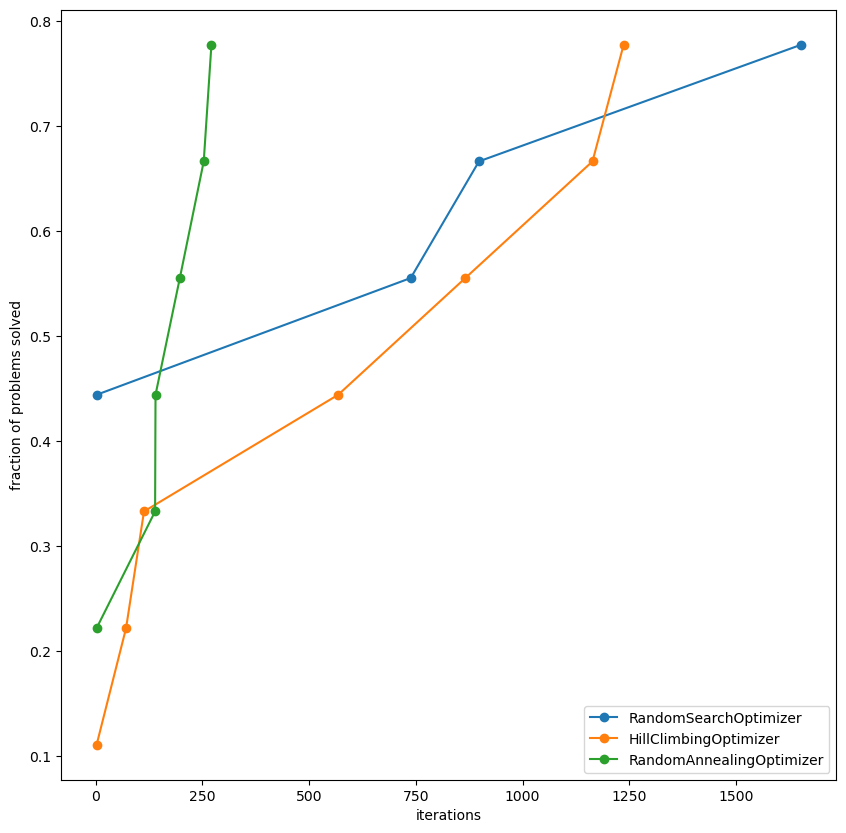

In [16]:
# create figure
total_problems = len(problems)
dict_all_results = {}
for solver, results in solver_solutions.items():
    dict_success = {}
    for problem, optimum in results.items():
        iteration = optimum[2]
        if np.isnan(iteration):
            continue
        if iteration in dict_success.keys():
            problem_count = dict_success.get(iteration)
            dict_success[iteration] = problem_count + 1
        else:
            dict_success[iteration] = 1
    dict_count = dict(sorted(dict_success.items()))
    dict_sums = {}
    problem_sum = 0
    for iteration, problem_count in dict_count.items():
        problem_sum += problem_count
        dict_sums[iteration] = problem_sum
    dict_fractions = {}
    for iteration, problem_sum in dict_sums.items():
        problem_fraction = round(problem_sum / total_problems, 4)
        dict_fractions[iteration] = problem_fraction
    dict_all_results[solver] = dict(sorted(dict_fractions.items()))

dict_figure = {}
for solver, results in dict_all_results.items():
    x_iteration = list(results.keys())
    y_fraction = list(results.values())
    dict_figure[solver] = [x_iteration, y_fraction]

fig, ax = plt.subplots(figsize=(10,10), dpi=100)
for solver, data in dict_figure.items():
    ax.plot(data[0], data[1], '-o', label=f'{solver}')
    ax.set_xlabel('iterations')
    ax.set_ylabel('fraction of problems solved')
    ax.legend();